## Plots delays, throughputs, packet loss and path for a selected link

In [1]:
%matplotlib inline
from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan
from datetime import datetime
import math
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import gridspec
from datetime import datetime
import numpy as np
import pandas as pd

es = Elasticsearch(['atlas-kibana.mwt2.org:9200'],timeout=60)
indices = "network_weather-2017.8.*"

my_query = {}

from sklearn import tree

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

import time
from sklearn.model_selection import train_test_split

##  Select your link

In [2]:
# sS='UC'
# srcSiteOWDServer = "192.170.227.160"
# srcSiteThroughputServer = "192.170.227.162"

sS='CERN-PROD'
srcSiteOWDServer = "128.142.223.247"
#srcSiteThroughputServer = "128.142.223.246"

# dS='IU'
# destSiteOWDServer = "149.165.225.223"
# destSiteThroughputServer = "149.165.225.224"

# dS='UIUC'
# destSiteOWDServer = "72.36.96.4"
# destSiteThroughputServer = "72.36.96.9"

# dS='ICCN'
# destSiteOWDServer = "72.36.96.4"
# destSiteThroughputServer = "72.36.126.132"

dS='pic'
destSiteOWDServer = "193.109.172.188"
#destSiteThroughputServer = "193.109.172.187"

## Get the data from Elasticsearch, and store the record based on its type

In [3]:
my_query = {
    'query': { 
       'bool':{
            'must':[
                    {'range': {'timestamp': {'gte': '20170807T000000Z', 'lt': '20170808T000000Z'}}},
                        {'bool':
                            {'should':[
                                {'term': {'src': srcSiteOWDServer}},
                                #{'term': {'src': srcSiteThroughputServer}},
                                #{'term': {'src': destSiteOWDServer}},
                                #{'term': {'src': destSiteThroughputServer}}
                            ]}
                        },
                        {'bool':
                            {'should':[
                                {'term': {'dest': destSiteOWDServer}},
                                #{'term': {'dest': destSiteThroughputServer}},
                                #{'term': {'dest': srcSiteOWDServer}},
                                #{'term': {'dest': srcSiteThroughputServer}}
                            ]}
                        }
                    ]
                }
        
        }
    }


scroll = list(scan(client=es, index=indices, query=my_query))


In [4]:
#site = {srcSiteOWDServer: sS, srcSiteThroughputServer: sS, destSiteOWDServer:dS, destSiteThroughputServer:dS}
site = {srcSiteOWDServer: sS, destSiteOWDServer:dS}
data = {sS:pd.DataFrame(),dS:pd.DataFrame()}
epoch = datetime.utcfromtimestamp(0)
count = 0
print(epoch)

for res in scroll:
    if count<10: print(res)
    count += 1
#     dt=datetime.strptime(res['_source']['timestamp'], '%Y-%m-%dT%H:%M:%S') # for data before Oct. 15 2016
    dt=datetime.utcfromtimestamp(res['_source']['timestamp']/1000.0)
    ts = (dt - epoch).total_seconds() * 1000.0
    s=site[res['_source']['src']]
    data[s].set_value(ts, 'timestamp', dt)
    column_type = res['_type']
#    if column_type == 'latency':
#        data[s].set_value( ts, 'delay_median', res['_source']['delay_median'])
#        data[s].set_value( ts, 'delay_mean', res['_source']['delay_mean'])
#        data[s].set_value( ts, 'delay_sd', res['_source']['delay_sd'])
    if column_type == 'packet_loss_rate':
        data[s].set_value( ts, 'packet_loss', res['_source']['packet_loss'])
#    elif column_type == 'throughput':
#        data[s].set_value( ts, 'throughput', res['_source']['throughput']/1024./1024./1024.)
#    elif column_type == 'traceroute':
#        data[s].set_value( ts, 'hash', res['_source']['hash'])
    if count<2: print(dt)

1970-01-01 00:00:00
{'_score': None, '_id': 'AV28L3R5NILXDji8oO7B', '_source': {'timestamp': 1502100597000, 'delay_median': 14.72, 'srcProduction': True, 'delay_mean': 14.743149999999998, 'srcVO': 'ATLAS', 'srcSite': 'CERN-PROD', 'destVO': 'ATLAS', 'delay_sd': 0.06875253328666034, 'dest': '193.109.172.188', 'destSite': 'pic', 'ipv6': False, 'MA': '128.142.223.247', 'src_host': 'perfsonar-lt.cern.ch', 'dest_host': 'psl01.pic.es', 'destProduction': True, 'src': '128.142.223.247'}, 'sort': [7708], '_index': 'network_weather-2017.8.7', '_type': 'latency'}
2017-08-07 10:09:57
{'_score': None, '_id': 'AV28L3R5NILXDji8oO7F', '_source': {'timestamp': 1502100176000, 'delay_median': 14.9, 'srcProduction': True, 'delay_mean': 14.999333333333334, 'srcVO': 'ATLAS', 'srcSite': 'CERN-PROD', 'destVO': 'ATLAS', 'delay_sd': 1.8531322732665962, 'dest': '193.109.172.188', 'destSite': 'pic', 'ipv6': False, 'MA': '128.142.223.247', 'src_host': 'perfsonar-lt.cern.ch', 'dest_host': 'psl01.pic.es', 'destProduc

In [5]:
data[sS].sort_index(inplace=True) 
data[sS].describe()

#data[dS].sort_index(inplace=True) 
#data[dS].describe()

print(data[sS])

                       timestamp  packet_loss
1.502064e+12 2017-08-07 00:00:10     0.005000
1.502064e+12 2017-08-07 00:00:34     0.006667
1.502064e+12 2017-08-07 00:01:10     0.006667
1.502064e+12 2017-08-07 00:01:35     0.001667
1.502064e+12 2017-08-07 00:02:10     0.000000
1.502064e+12 2017-08-07 00:02:35     0.000000
1.502064e+12 2017-08-07 00:03:10     0.003333
1.502064e+12 2017-08-07 00:03:35     0.000000
1.502064e+12 2017-08-07 00:04:10     0.001667
1.502064e+12 2017-08-07 00:04:35     0.003333
1.502064e+12 2017-08-07 00:05:10     0.001667
1.502064e+12 2017-08-07 00:05:35     0.001667
1.502064e+12 2017-08-07 00:06:10     0.005000
1.502064e+12 2017-08-07 00:06:35     0.001667
1.502064e+12 2017-08-07 00:07:10     0.001667
1.502064e+12 2017-08-07 00:07:35     0.000000
1.502064e+12 2017-08-07 00:08:10     0.001667
1.502065e+12 2017-08-07 00:08:35     0.001667
1.502065e+12 2017-08-07 00:09:10     0.001667
1.502065e+12 2017-08-07 00:09:35     0.001667
1.502065e+12 2017-08-07 00:10:10  

### Extract values

In [6]:
F = data[sS]
#B = data[dS]
#Fthr = F[F.throughput.notnull()]    # Get the lines (i.e. times) whose throughput is not null
#Bthr = B[B.throughput.notnull()]  
Fpl = F[F.packet_loss.notnull()]
#Bpl = B[B.packet_loss.notnull()]
# Fd = F[F.delay_mean.notnull()]
# Bd = B[B.delay_mean.notnull()]
#Fd = F[F.delay_mean<150]
#Bd = B[B.delay_mean<150]
#Jd = Fd.join(Bd,how='inner', rsuffix="_back")
#Jd['dmean']= (Jd.delay_mean + Jd.delay_mean_back)/2

#Fh = F[F.hash.notnull()]
#Bh = B[B.hash.notnull()]
Fids=[];Bids=[]
Fu=[];Bu=[]

#for fi in Fh.hash.tolist():
#    if fi not in Fu: Fu.append(fi)
#    Fids.append(Fu.index(fi))
#for fi in Bh.hash.tolist():
#    if fi not in Bu: Bu.append(fi)
#    Bids.append(Bu.index(fi))

#### interpolate all the values and leave only onese where all 4 measurements are there

In [7]:
NF=F.interpolate(method='index',limit=1,limit_direction='both')
#NFall = NF[NF.throughput.notnull()]
#NFall = NFall[NFall.delay_mean.notnull()]
NFall = NF[NF.packet_loss.notnull()]
#NFall = NFall[NFall.hash.notnull()]

#NB=B.interpolate(method='index',limit=1,limit_direction='both')
#NBal = NB[NB.throughput.notnull()]
#NBall = NB[NB.delay_mean.notnull()]
#NBall = NB[NB.packet_loss.notnull()]
print(NFall.shape)

(2914, 2)


In [8]:
#print(NF)
#print(NB)

print(NF.shape)
#print(NB.shape)

(2914, 2)


In [9]:
#print( 'throughput  forward: ', Fthr.shape[0], ' backward: ', Bthr.shape[0])
#print( 'packet loss forward: ', Fpl.shape[0],  ' backward: ', Bpl.shape[0])
print( 'packet loss forward: ', Fpl.shape[0])
#print( 'delay       forward: ', Fd.shape[0],   ' backward: ', Bd.shape[0])
#print( 'hash        forward: ', Fh.shape[0],   ' backward: ', Bh.shape[0])

#i=0
#while i < Fpl.shape[0]:
#    print("Hi")
#    i = i + 1

packet loss forward:  2802


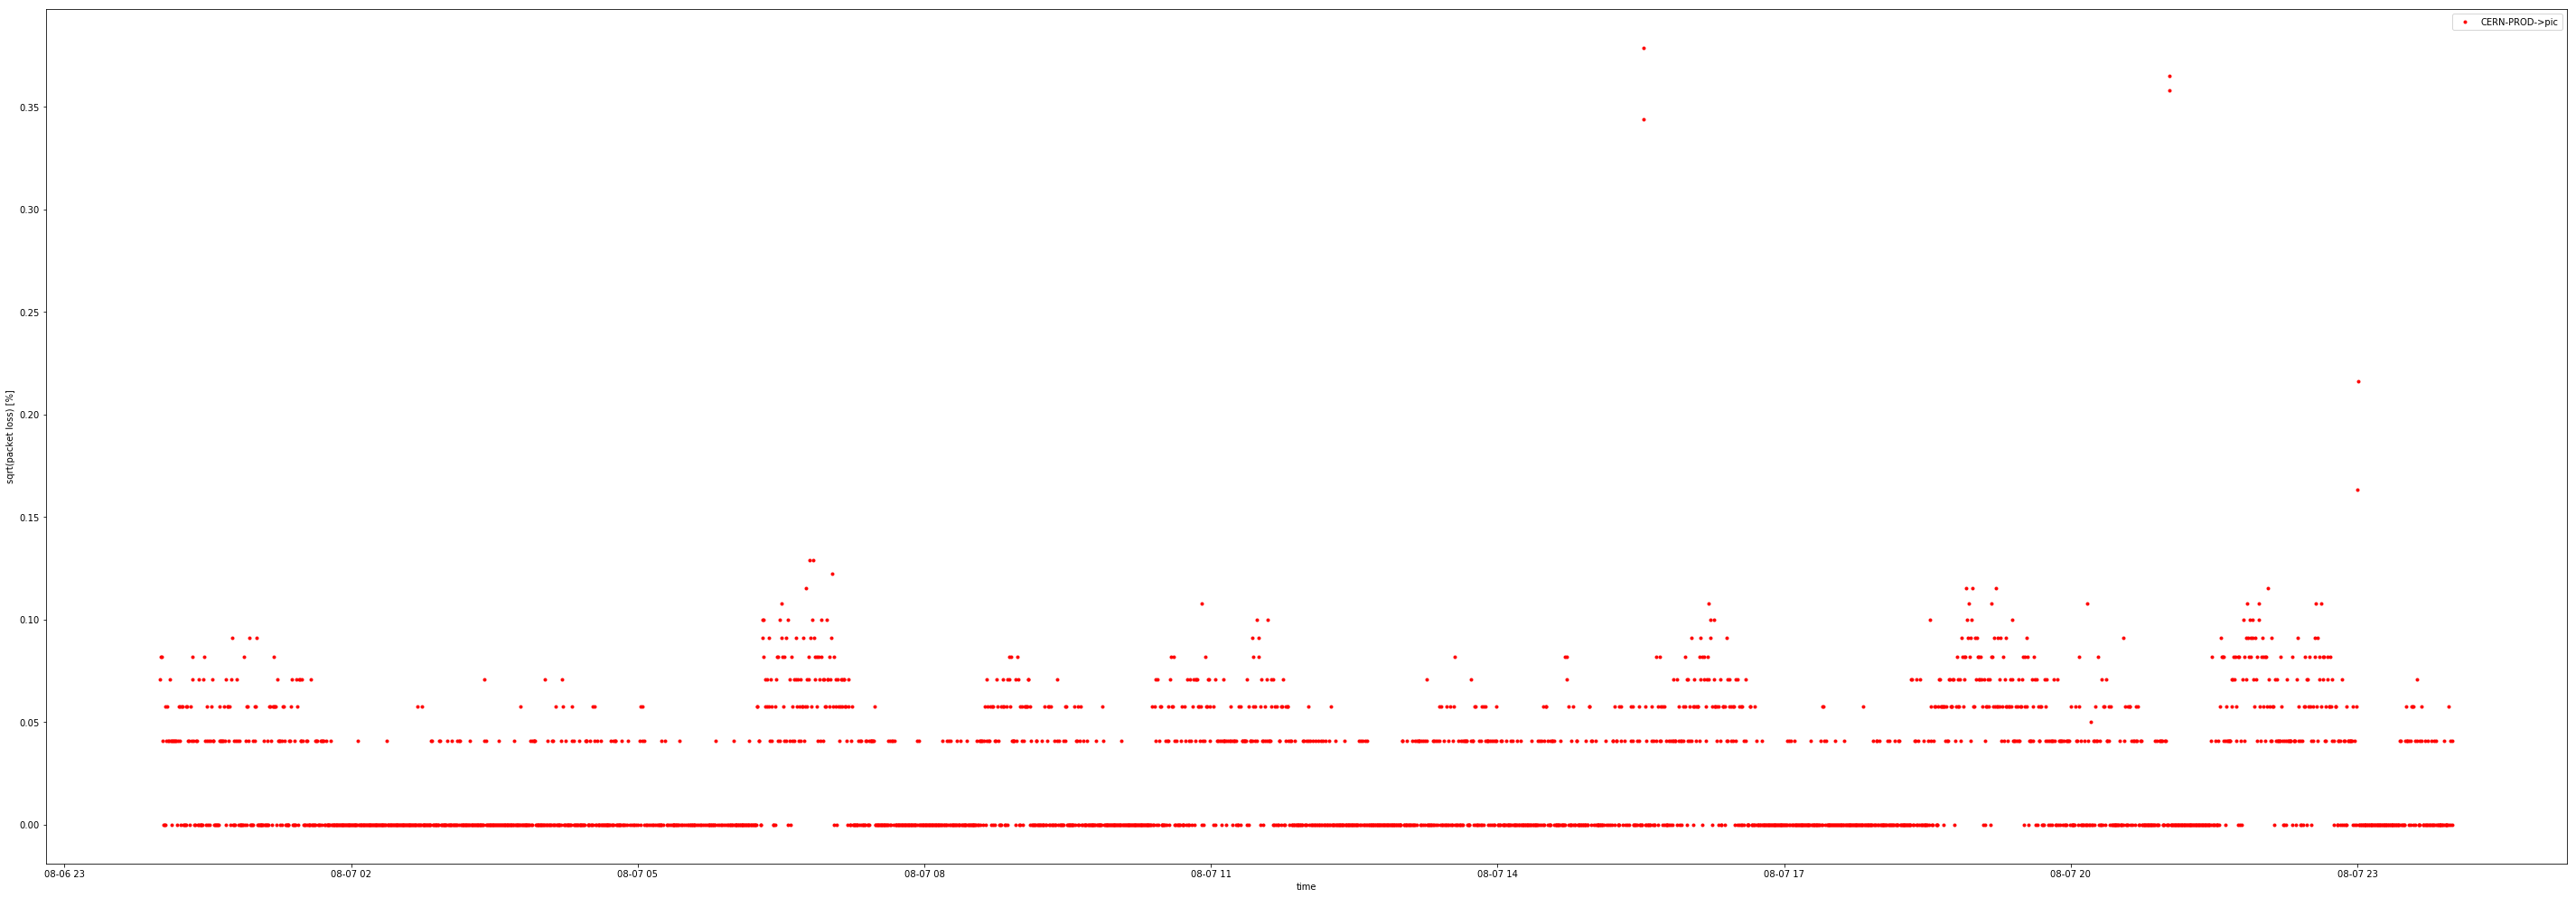

In [10]:
plt.figure(figsize=[50, 80])
gs = gridspec.GridSpec(4, 1)

ax2 = plt.subplot(gs[1])
ax2.plot(Fpl.timestamp.tolist(), np.sqrt(Fpl.packet_loss).tolist(), ls='', marker='.', c='r', label=sS+'->'+dS)
ax2.set_xlabel('time')
ax2.set_ylabel('sqrt(packet loss) [%]')
ax2.legend()

plt.show()